In [1]:
import numpy as np 
import pandas as pd 
import gc
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch 
import pytorch_lightning as pl
import torchmetrics
from torch import nn
from torch.utils.data import DataLoader
torch.manual_seed(42)


# return bottleneck and his shortcut
class BigBottleneck(nn.Module):
    def __init__(self, in_channels, kernels, is_shortcut=False):
        super(BigBottleneck, self).__init__()
        k1, k2, k3  = kernels
        first_stride = 2 if is_shortcut else 1
    
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, k1, 1, first_stride, bias=False),
            nn.BatchNorm2d(k1),
            nn.ReLU(inplace=True),
        
            nn.Conv2d(k1, k2, 3, bias=False, padding=1),
            nn.BatchNorm2d(k2),
            nn.ReLU(inplace=True),
        
            nn.Conv2d(k2, k3, 1, bias=False),
            nn.BatchNorm2d(k3)
        )
    
        self.shortcut = None
        if is_shortcut:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, k3, 1, 2, bias=False),
                nn.BatchNorm2d(k3)
            )
        else:
            self.shortcut = nn.Identity()
            
        self.last_relu = nn.ReLU()
    
    def forward(self, inp):
        x = self.bottleneck(inp) + self.shortcut(inp)
        return self.last_relu(x)
        
        
# resnet50 model
class Resnet50(nn.Module):
    def __init__(self, in_channels=3):
        super(Resnet50, self).__init__()
        
        self.start = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        # 1, 2, 3, 4 layers
        layer1 = [BigBottleneck(64, [64, 64, 256], is_shortcut=True)] + [BigBottleneck(256, [64, 64, 256]) for _ in range(1, 3)] 
        layer2 = [BigBottleneck(256, [128, 128, 512], is_shortcut=True)] + [BigBottleneck(512, [128, 128, 512]) for _ in range(1, 4)] 
        layer3 = [BigBottleneck(512, [256, 256, 1024], is_shortcut=True)] + [BigBottleneck(1024, [256, 256, 1024]) for _ in range(1, 6)] 
        layer4 = [BigBottleneck(1024, [512, 512, 2048], is_shortcut=True)] + [BigBottleneck(2048, [512, 512, 2048]) for _ in range(1, 3)]
        layers = layer1 + layer2 + layer3 + layer4
        self.body = nn.Sequential(*layers)
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 1000),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )
        
        
    def forward(self, inp):
        x = self.start(inp)
        x = self.body(x)
        return self.classifier(x)
        
        
class LITResnet50(pl.LightningModule):
    def __init__(self, lr=1e-5):
        super().__init__()
        self.lr = lr
        self.model = Resnet50()
        self.loss_f = nn.BCELoss()
        self.roc_auc_f = torchmetrics.AUROC(num_classes=1)
        self.f1_f = torchmetrics.F1()
        self.scores = {
            'val_loss': [],
            'val_f1': [],
            'val_rocauc': [],
            'train_loss': [],
            'train_rocauc': [],
            'train_f1': []
        }
        self.first_epoch = True
        
        
    def forward(self, inp):
        return self.model(inp)
    

    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr=self.lr)

                                
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
                                
        pred_y = self.model(x)
        pred_y = torch.flatten(pred_y)
        pred_y = pred_y.type(torch.float64)              
        return self.loss_f(pred_y, y)
    
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        
        pred_y = self.model(x)
        pred_y = torch.flatten(pred_y)
        pred_y = pred_y.type(torch.float64)
                                
        loss = self.loss_f(pred_y, y)
        self.log("train_loss", loss, on_epoch=True, logger=True)
        
        return {'loss': loss, 'pred': pred_y, 'y': y}
    
    
    def training_epoch_end(self, outputs):
        preds, targs = [], []
        for out in outputs:
            preds.append(out['pred'])
            targs.append(out['y'])
            
        preds = torch.cat(tensors=preds)
        targs = torch.cat(tensors=targs)
        
        rocauc = self.roc_auc_f(preds, targs.type(torch.int))
        loss = self.loss_f(preds, targs)
        f1 = self.f1_f(preds, targs.type(torch.int))
        
        self.log("train_roc_auc", rocauc, logger=True, on_epoch=True)
        
        self.scores['train_loss'].append(loss)
        self.scores['train_f1'].append(f1)
        self.scores['train_rocauc'].append(rocauc)

    
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
               
        pred_y = self.model(x)
        pred_y = torch.flatten(pred_y)
        pred_y = pred_y.type(torch.float64)
           
        loss = self.loss_f(pred_y, y)
        self.log("val_loss", loss, on_epoch=True, logger=True)
        
        return {
            'y': y, 
            'pred': pred_y
        }
    
    
    def validation_epoch_end(self, outputs):
        preds, targs = [], []
        for out in outputs:
            preds.append(out['pred'])
            targs.append(out['y'])
            
        preds = torch.cat(tensors=preds)
        targs = torch.cat(tensors=targs)
        
        rocauc = self.roc_auc_f(preds, targs.type(torch.int))
        loss = self.loss_f(preds, targs)
        f1 = self.f1_f(preds, targs.type(torch.int))
        
#         print("Preds shape: ", preds.shape)
#         print("Targs shape: ", targs.shape)
        
#         print("rocauc ptl: ", rocauc)
#         print("rocauc sklearn: ", roc_auc_score(list(map(int, torch.flatten(targs).tolist())), torch.flatten(preds).tolist()))
        
        self.log("val_roc_auc", rocauc, logger=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", loss, logger=True, on_epoch=True, prog_bar=True)
        if not self.first_epoch:# because method call in start training
            self.scores['val_loss'].append(loss)
            self.scores['val_f1'].append(f1)
            self.scores['val_rocauc'].append(rocauc)
        self.first_epoch = False
   
    
class PseudoRGBDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, pimgs, idxs=None):
        # load df
        df = pd.read_csv(csv_path)
        if not idxs is None:
            df = df.iloc[idxs]
        # process data
        self.data = []
        for _, r in df.iterrows():
            bid, target = r['BraTS21ID'], r['MGMT_value']
            if pimgs[bid] == -1:
                continue
            self.data += [(torch.from_numpy(np.moveaxis(pimgs[bid][i], -1, 0)), float(target)) for i in range(1)]
            gc.collect()
                
        del pimgs, df
        gc.collect()
            
            
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        return self.data[idx]

In [2]:
if __name__ == "__main__":
    RANDOM_SEED = 42
    TEST_SIZE = 0.3
    BATCH_SIZE = 16
    
    pimgs_path = "../input/get-data-pseudorgb-v1-flair-train/pseudorgb_v1_flair_train.joblib"
    df_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv"
    
    pimgs = joblib.load(pimgs_path)
    df = pd.read_csv(df_path)
    X, y = list(range(len(df))), df['MGMT_value'].tolist()
    assert len(X) == len(y)
    train_idx, test_idx, _, _ = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)
    print(f"Test idx: {test_idx} \nLen: {len(test_idx)}")

    
    train_data, test_data = PseudoRGBDataset(df_path, pimgs, train_idx), PseudoRGBDataset(df_path, pimgs, test_idx)
    train_data = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
    test_data = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    
    del df, X, y, pimgs
    gc.collect()


Test idx: [342, 260, 284, 41, 49, 556, 38, 262, 80, 376, 384, 322, 527, 254, 343, 173, 422, 31, 310, 90, 112, 328, 238, 430, 380, 47, 88, 234, 202, 160, 321, 547, 55, 404, 582, 54, 102, 518, 324, 568, 576, 40, 494, 36, 386, 114, 433, 355, 515, 125, 172, 570, 228, 309, 145, 7, 201, 198, 106, 436, 21, 146, 16, 209, 435, 58, 406, 261, 320, 480, 210, 349, 306, 425, 464, 387, 109, 474, 179, 11, 345, 194, 29, 275, 107, 305, 287, 523, 131, 33, 330, 428, 20, 333, 331, 256, 548, 50, 336, 447, 192, 354, 516, 57, 485, 545, 230, 506, 481, 95, 373, 521, 540, 531, 353, 30, 200, 519, 424, 113, 483, 427, 487, 409, 416, 211, 164, 4, 575, 174, 561, 60, 577, 315, 492, 361, 282, 381, 419, 566, 185, 456, 216, 501, 205, 318, 388, 257, 62, 441, 459, 43, 105, 258, 86, 176, 446, 78, 554, 449, 584, 539, 389, 130, 69, 563, 526, 126, 91, 377, 98, 6, 288, 273, 121, 497] 
Len: 176


/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
2021-09-14 21:16:19.209979: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:373: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:323: UserWarning: The number of training samples (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'y', 'pred'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

0.6323610544204712


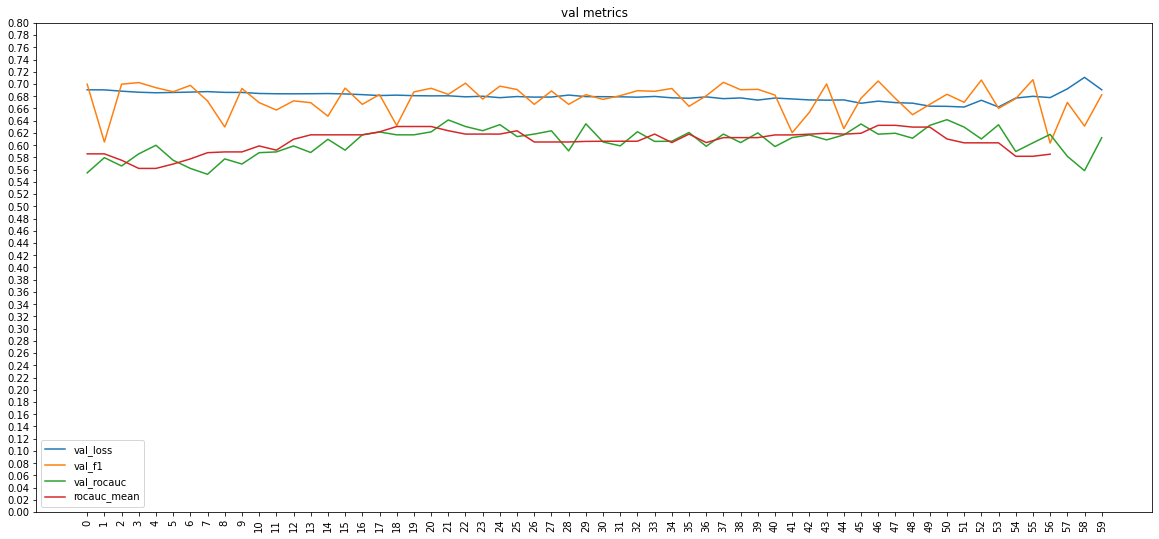

In [3]:
# axial
GPUS = 1
EPOCHS = 60
LR = 1e-6
    
# train

model = LITResnet50(lr=LR)
save_callback = pl.callbacks.ModelCheckpoint(
    dirpath="./",
    filename='TEST-{epoch}-{val_roc_auc:.2f}-{val_loss:.2f}',
    monitor='val_loss',
    mode='min',
    save_last=True,
    save_on_train_epoch_end=False,
    save_top_k=5
)
trainer = pl.Trainer(max_epochs=EPOCHS, gpus=GPUS, callbacks=[save_callback])
trainer.fit(model, train_data, test_data)

# visualize metrics
scores = model.scores
_, axs = plt.subplots(figsize=(20, 9))

n = 3
max_yticks = 0.8
plt.yticks([i/50 for i in range(int(max_yticks*100))])
plt.xticks(list(range(len(scores['val_loss']))), rotation=90)
for k, v in scores.items():
    if 'val' in k:
        sc = [s.item() for s in scores[k]]
        sns.lineplot(list(range(len(scores['val_loss']))), sc, ax=axs, label=k).set_title('val metrics')
val_rocauc = [s.item() for s in scores['val_rocauc']]
mean_val_rocauc = [np.median(val_rocauc[i-(n//2):i+int(np.ceil(n/2))]) for i in range(n, len(scores['val_rocauc']))]
sns.lineplot(list(range(len(mean_val_rocauc))), mean_val_rocauc, ax=axs, label='rocauc_mean')
axs.set_ylim(0, max_yticks)
print(max(mean_val_rocauc))

In [4]:
# test_img_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/"
# submit_sub_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv'
# model_path = "./TEST-epoch=11-val_roc_auc=0.61-train_roc_auc=0.98.ckpt"
    
# # loadmodel
# state_dict = torch.load(model_path, map_location=torch.device('cpu'))['state_dict']
# state_dict = {k.lstrip('model.'):v for k, v in state_dict.items()}
# model = Resnet50()
# model.load_state_dict(state_dict)
# model.eval()

In [5]:
# #targs = [t[1] for t in train_data]
# #targs = list(itertools.chain(*targs))

# targs = []
# preds = []
# for t in train_data:
#     targs += t[1]
#     inp = t[0] 
#     out = model(inp)
#     out = torch.flatten(out).tolist()
#     preds += out
#     gc.collect()
    
# roc_auc_score(targs, preds)